## Grid Sapientino.

Level of abstraction "one", with restraining bolts.

The goal is to visit N colors in a certain order.

pygame 2.0.0.dev12 (SDL 2.0.12, python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html
Before temporal goal wrapper:
Observation space: Dict(beep:Discrete(2), color:Discrete(8), x:Discrete(7), y:Discrete(5))
Action space: Discrete(6)
After temporal goal wrapper:
Observation space: Tuple(Dict(beep:Discrete(2), color:Discrete(8), x:Discrete(7), y:Discrete(5)), MultiDiscrete([6]))
Action space: Discrete(6)


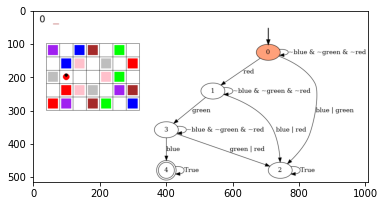

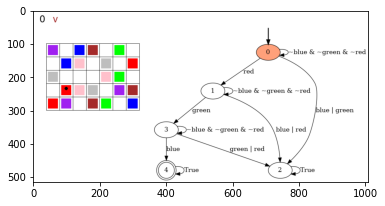

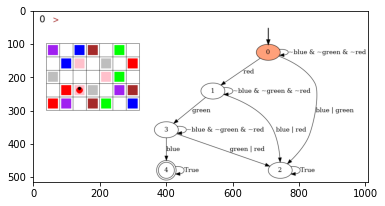

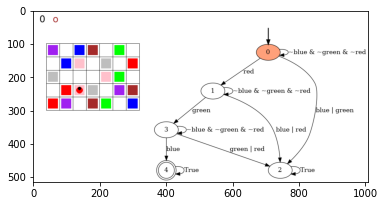

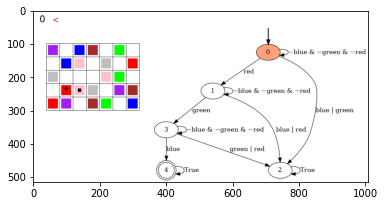

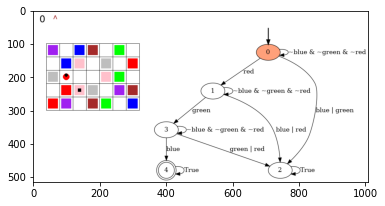

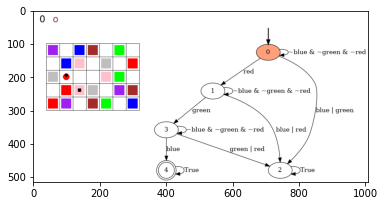

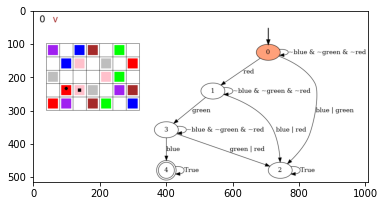

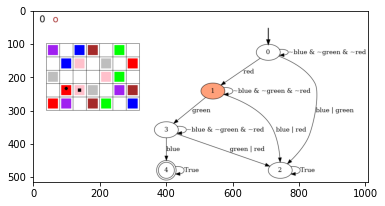

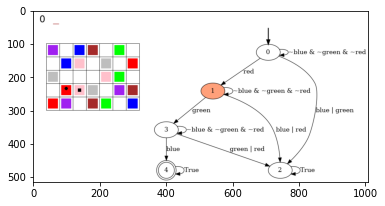

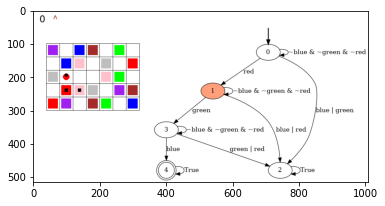

In [1]:
%matplotlib inline

from gym_sapientino import SapientinoDictSpace
from multinav.helpers.gym import rollout, SingleAgentWrapper
from multinav.helpers.notebooks import plot_env
from multinav.helpers.temprl import MyTemporalGoalWrapper
from multinav.restraining_bolts.rb_grid_sapientino import GridSapientinoRB

nb_colors = 3
env = SingleAgentWrapper(SapientinoDictSpace())
tg = GridSapientinoRB(nb_colors).make_sapientino_goal()
print("Before temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
env = MyTemporalGoalWrapper(env, [tg])
print("After temporal goal wrapper:")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

rollout(env, callback=plot_env)